---
title: T2M Nonstationary - Analysis
subject: AEMET T2M
short_title: 3 - Analysis
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CSIC
      - UCM
      - IGEO
    orcid: 0000-0002-6739-0053
    email: juanjohn@ucm.es
license: CC-BY-4.0
keywords: notation
---

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "" # first gpu
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'FALSE'

import jax
jax.config.update('jax_platform_name', 'cpu')

import numpyro
import multiprocessing

num_devices = multiprocessing.cpu_count()
numpyro.set_platform("cpu")
numpyro.set_host_device_count(num_devices)

In [4]:
import autoroot
from pathlib import Path
import numpy as np
import xarray as xr
import pandas as pd
import pint_xarray
import arviz as az
from omegaconf import OmegaConf

from st_evt.utils import ExperimentPath
from st_evt.viz import (
    plot_scatter_ts,
    plot_histogram,
    plot_density,
    plot_return_level_gevd_manual_unc_multiple,
    plot_periods,
    plot_periods_diff
)
from st_evt.extremes import estimate_return_level_gevd, calculate_exceedence_probs

import jax
import jax.random as jrandom
import jax.numpy as jnp
import pandas as pd

rng_key = jrandom.PRNGKey(123)

from numpyro.infer import Predictive
import arviz as az

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
import xarray as xr
import regionmask

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%config InlineBackend.figure_format = 'retina'
plt.style.use(
    "https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle"
)


# num_devices = 5
# numpyro.set_host_device_count(num_devices)


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [5]:
config_file_name = "/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_station_stationary/config/config.json"
config = OmegaConf.load(config_file_name)

config

{'experiment_name': 'walkthrough/ts_station_stationary', 'dataset': 'aemet', 'station_id': '8414A', 'variable': 't2m', 'likelihood': 'gevd', 'freq': 'summer', 'dependence': 'temporal', 'parameterization': 'linear', 'config_file_name': 'aemet_station_nonstationary.yaml', 'covariate_path': '/home/juanjohn/pool_data/dynev4eo/data/clean/gmst.zarr', 'dataset_path': '/home/juanjohn/pool_data/dynev4eo/data/clean/t2m_stations_spain.zarr', 'exp_path': '/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_station_stationary', 'figures_path': '/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_station_stationary/figures/eda', 'data_path': '/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_station_stationary/data', 'clean_data_path': '/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_station_stationary/data/clean_data.nc', 'mcmc_results_path': '/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_station_stationary/data/mcmc_results.nc'}

### Data

In [6]:
root_path = Path(config["exp_path"])
clean_data_path = Path(config["clean_data_path"])
covariate_data_path = Path(config["covariate_path"])
results_data_path = Path(config["mcmc_results_path"])


exp_file_config = ExperimentPath(root_dir=root_path)
figures_path = exp_file_config.figures_results_dir
data_path = exp_file_config.data_dir

### Data

In [7]:
with xr.open_dataset(clean_data_path, engine="netcdf4") as f:
    ds_station = f.load()
ds_station

<xarray.Dataset> Size: 1kB
Dimensions:          (gmst: 60, station_id: 1, quantile: 5)
Coordinates:
    alt              (station_id) float32 4B 56.0
    lat              (station_id) float32 4B 39.48
    lon              (station_id) float32 4B -0.476
    red_feten_mask   (station_id) uint8 1B 1
  * station_id       (station_id) <U5 20B '8414A'
    station_name     (station_id) <U20 80B 'valencia, aeropuerto'
    time             (gmst) datetime64[ns] 480B 1961-12-31 ... 2020-12-31
  * gmst             (gmst) float64 480B 0.1988 0.1827 0.1587 ... 1.133 1.196
  * quantile         (quantile) float64 40B 0.9 0.95 0.98 0.99 0.995
Data variables:
    t2m_max_bm_year  (gmst, station_id) float32 240B 35.8 43.4 ... 42.4 36.5
    threshold        (quantile) float64 40B 33.0 34.5 36.4 37.6 38.65

#### MCMC Results

In [8]:

az_ds = az.from_netcdf(results_data_path)
az_ds

Inference data with groups:
	> posterior
	> posterior_predictive
	> predictions
	> log_likelihood
	> sample_stats
	> prior
	> observed_data

## Posterior Calculations

In [9]:
# from dynev4eo._src.postprocess.math import calculate_posterior_variables_gevd

### Return Level

In [10]:



RETURN_PERIODS_GEVD = np.logspace(0.001, 4, 100)

fn_gevd = jax.jit(estimate_return_level_gevd)

def calculate_return_period(return_periods, location, scale, shape):
    rl = jax.vmap(fn_gevd, in_axes=(0,None,None,None))(return_periods, location, scale, shape)
    return rl

In [11]:
az_ds.predictions["return_level_100"] = xr.apply_ufunc(
    calculate_return_period,
    [100],
    az_ds.predictions.location,
    az_ds.predictions.scale,
    az_ds.predictions.concentration,
    input_core_dims=[[""], ["draw"], ["draw"], ["draw"]],
    output_core_dims=[["draw"]],
    vectorize=True
)

az_ds.predictions["return_level"] = xr.apply_ufunc(
    calculate_return_period,
    RETURN_PERIODS_GEVD,
    az_ds.predictions.location,
    az_ds.predictions.scale,
    az_ds.predictions.concentration,
    input_core_dims=[["return_period"], ["draw"], ["draw"], ["draw"]],
    output_core_dims=[["return_period", "draw"]],
    vectorize=True
)
az_ds = az_ds.assign_coords({"return_period": RETURN_PERIODS_GEVD})
az_ds

Inference data with groups:
	> posterior
	> posterior_predictive
	> predictions
	> log_likelihood
	> sample_stats
	> prior
	> observed_data

## Model Inspection

### Trace Plot

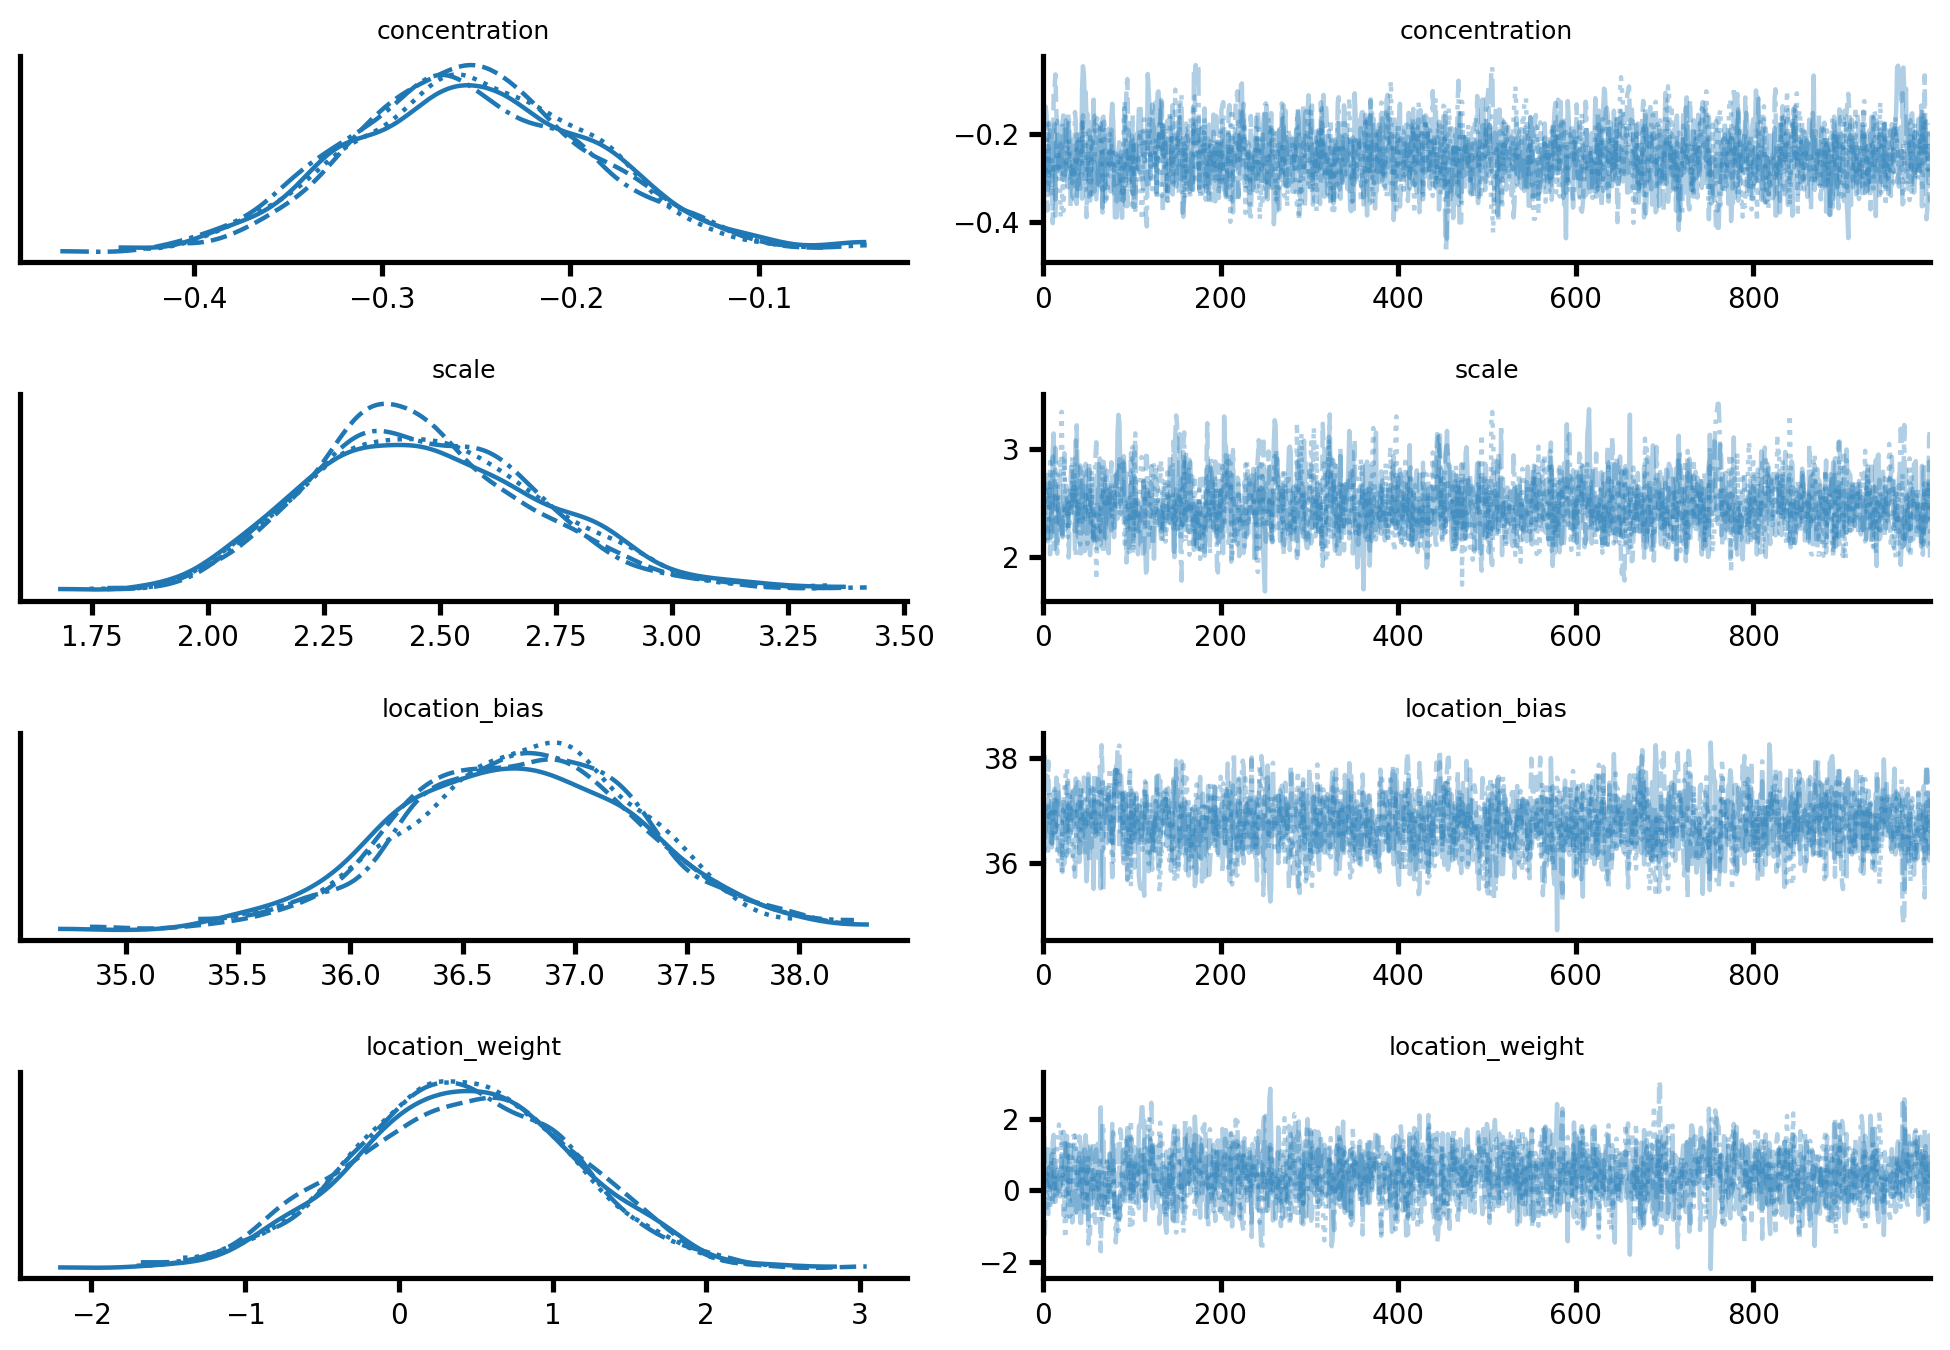

In [12]:
variables = [
    "concentration",
    "scale",
    "location_bias",
    "location_weight", 
    # "sigma", "rate",
    # "return_level_100",
    ]





fig = az.plot_trace(
    az_ds.posterior, 
    var_names=variables,
    figsize=(10, 7)
);
plt.savefig(figures_path.joinpath("trace.png"))
plt.gcf().set_dpi(100)
plt.show()

### Joint Plot

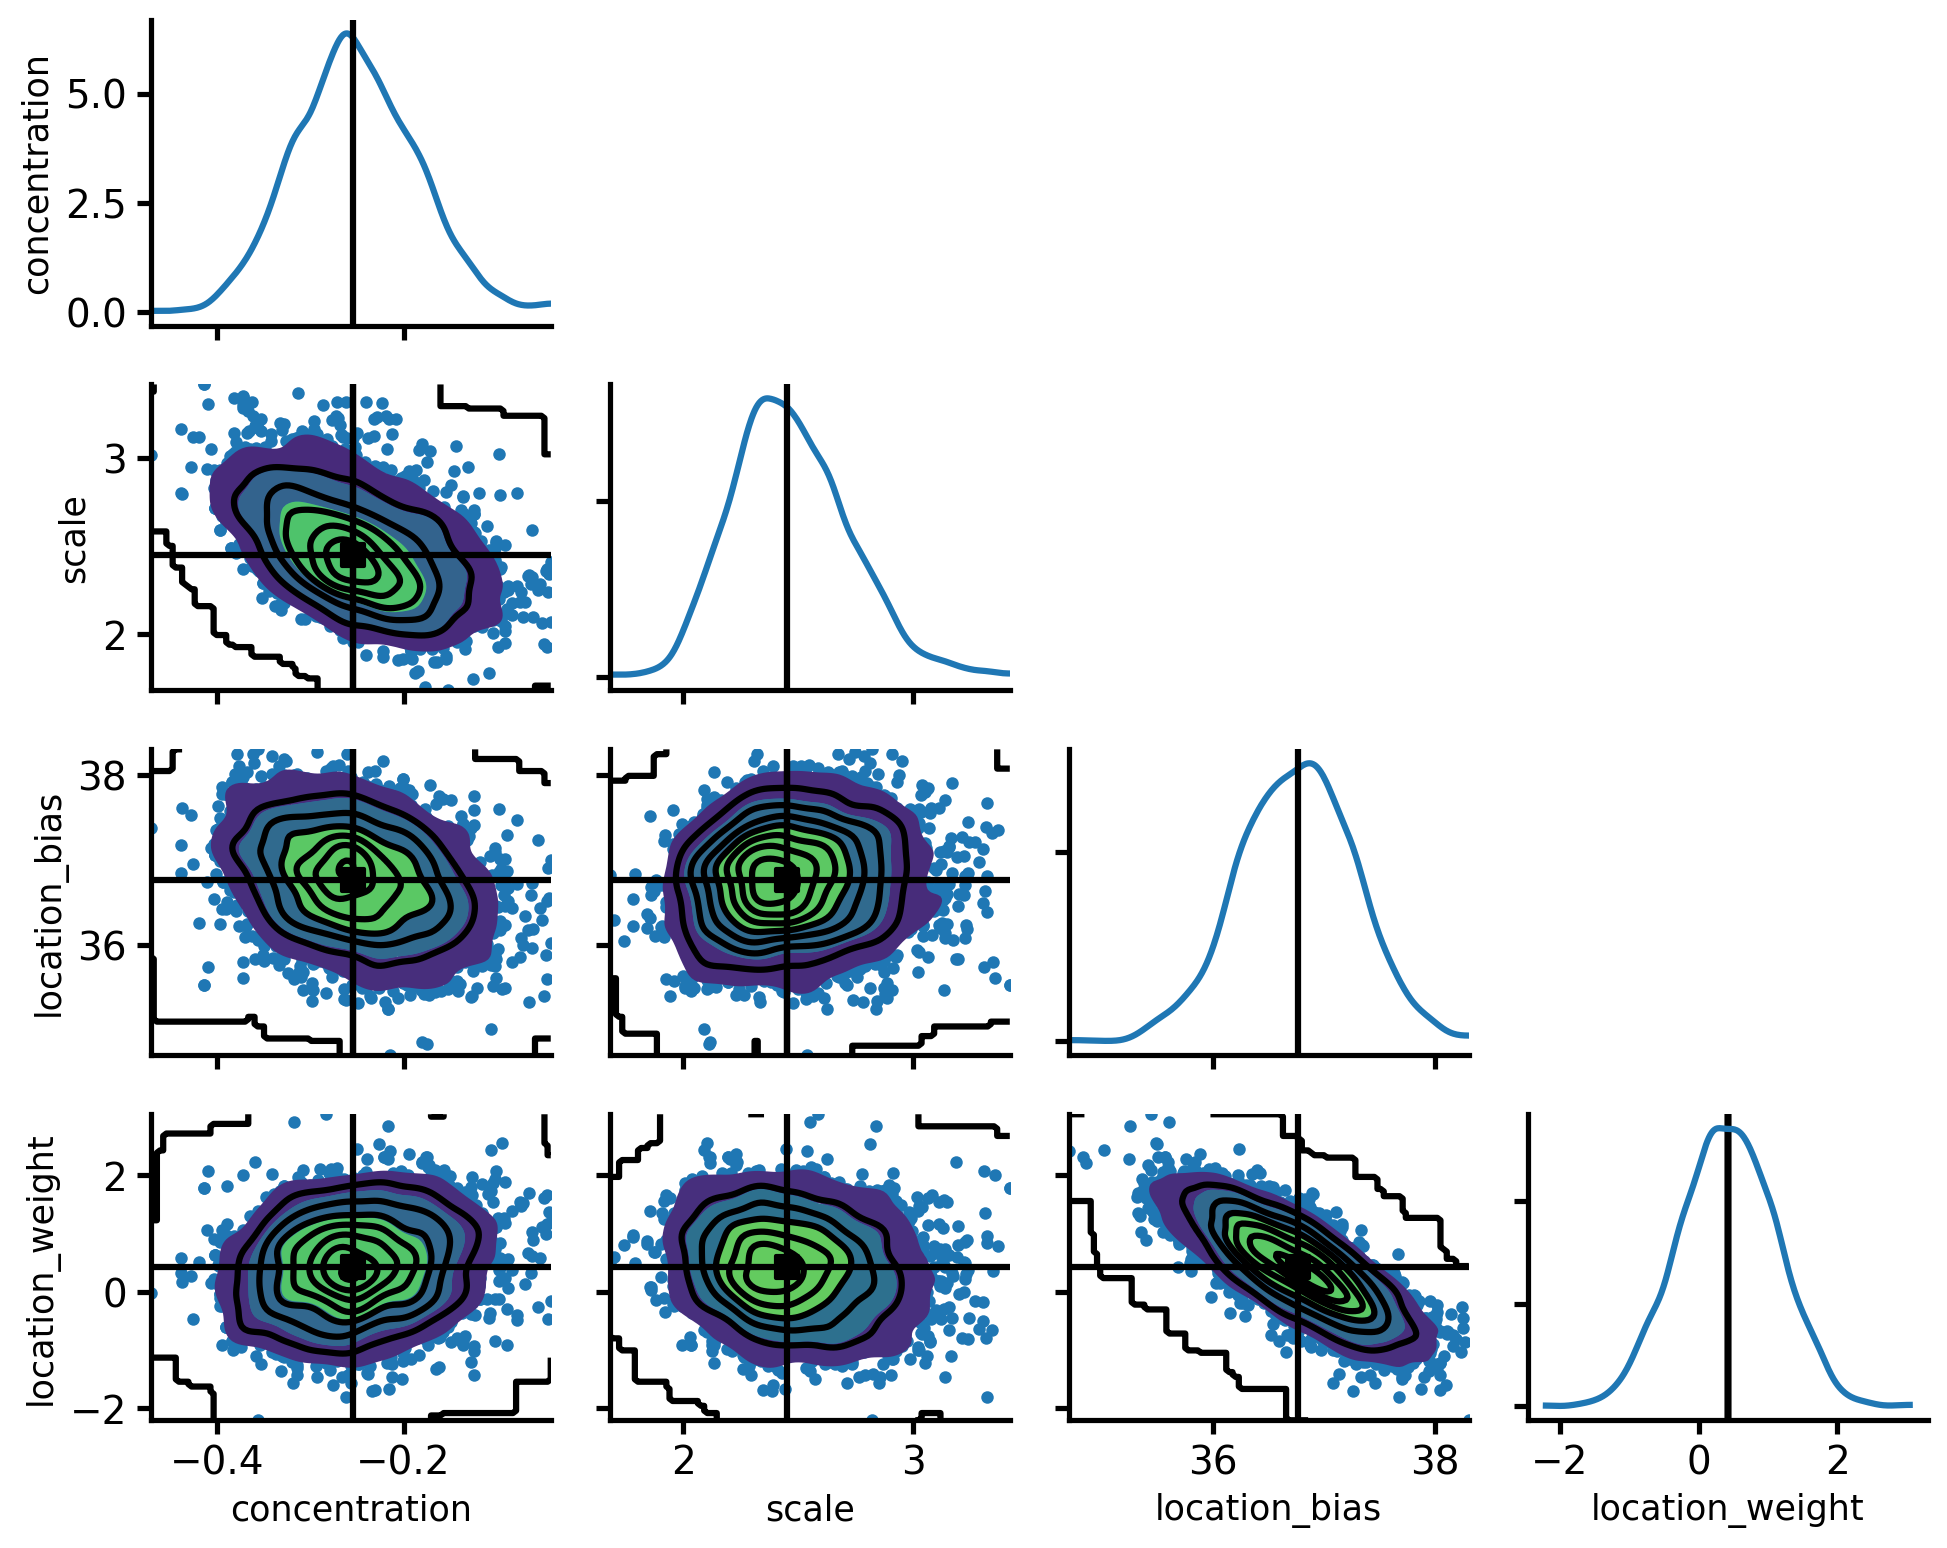

In [13]:
fig = az.plot_pair(
    az_ds.posterior,
    # group="posterior",
    var_names=variables,
    kind=["scatter", "kde"],
    kde_kwargs={"fill_last": False},
    marginals=True,
    # coords=coords,
    point_estimate="median",
    figsize=(10, 8),
)
plt.tight_layout()
plt.savefig(figures_path.joinpath("params_joint.png"))
plt.gcf().set_dpi(100)
plt.show()

### Regression Plot

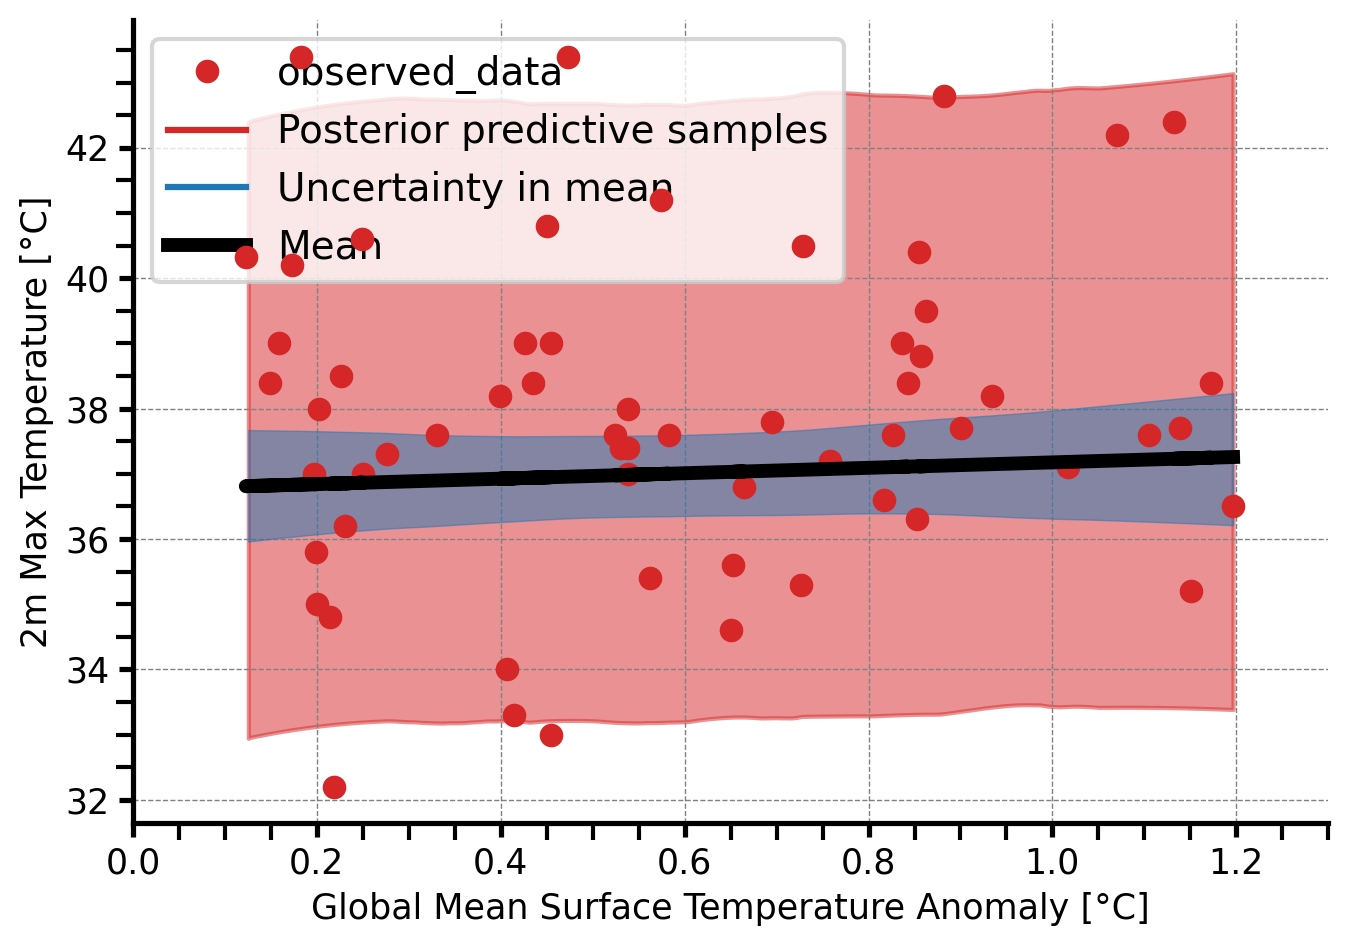

In [14]:
# X-VARIABLE
x = az_ds.posterior.gmst

# Y-Observations
y = az_ds.observed_data.obs

# POSTERIOR SAMPLES
y_hat = az_ds.posterior_predictive["obs"]

# PREDICTIONS
y_model = az_ds.posterior["location_weight"] * x + az_ds.posterior["location_bias"]


# INITIALIZE PLOT
fig, ax = plt.subplots()

# PLOT KWARGS
kind_pp = "hdi"
kind_model = "hdi"
y_hat_plot_kwargs = dict(
    color="tab:red",
    markersize=10.0
)
y_model_mean_kwargs = dict(
    color="black",
    linewidth=5.0,
)

# PLOT
az.plot_lm(
    axes=ax,
    y=y, y_hat=y_hat, x=x, y_model=y_model,
    kind_pp=kind_pp, kind_model=kind_model,
    y_hat_plot_kwargs=y_hat_plot_kwargs,
    y_model_mean_kwargs=y_model_mean_kwargs,
)

ax.set(
    xlabel="Global Mean Surface Temperature Anomaly [°C]",
    ylabel="2m Max Temperature [°C]",
    xlim=[0.0, 1.3]
)
plt.grid(True, linestyle='--', linewidth='0.5', color='gray')
plt.minorticks_on()
fig.set(
    dpi=100,
    size_inches=(7,5)
)
plt.savefig(figures_path.joinpath("regression_posterior_samples.png"))
plt.tight_layout()
plt.show()

## Model Critique

In [15]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from tensorflow_probability.substrates.jax import distributions as tfd
# error = 

In [16]:
idata = az.extract(az_ds, group="posterior_predictive", num_samples=10_000)


y_pred = az_ds.posterior_predictive.obs.rename("y_pred")
y_true = az_ds.observed_data.obs

In [17]:
y_error = y_pred - y_true

### Density - Residual Error

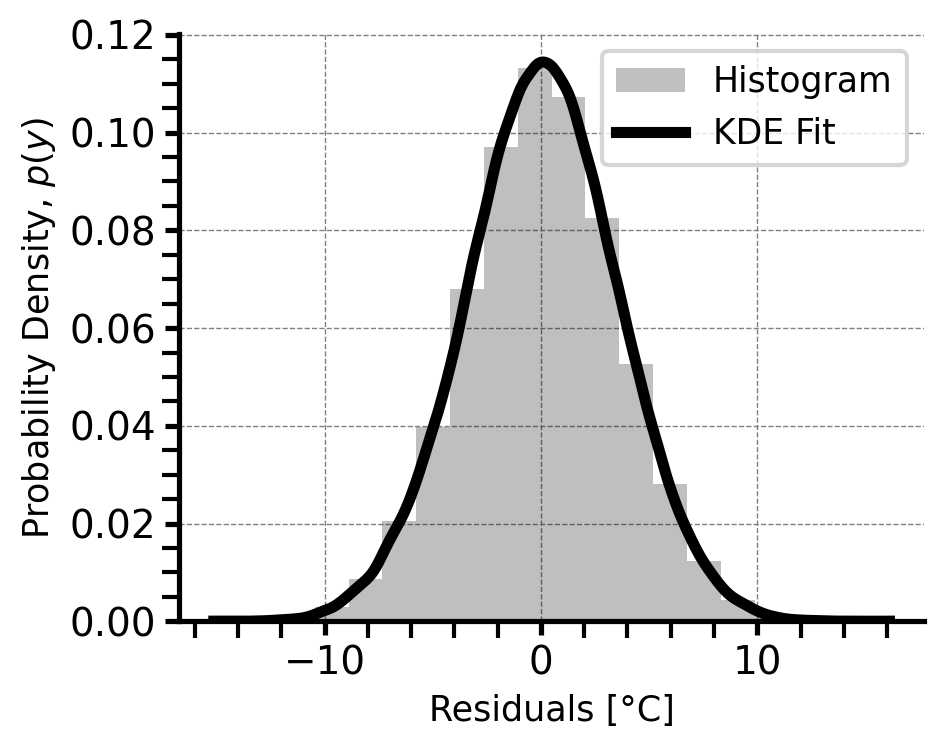

In [18]:
fig, ax = plot_density(y_error)
ax.set(
    title="",
    xlabel="Residuals [°C]"
)
fig.set(
    dpi=100,
    size_inches=(5,4)
)
plt.tight_layout()
fig.savefig(figures_path.joinpath("metric_density_residuals.png"))
plt.show()

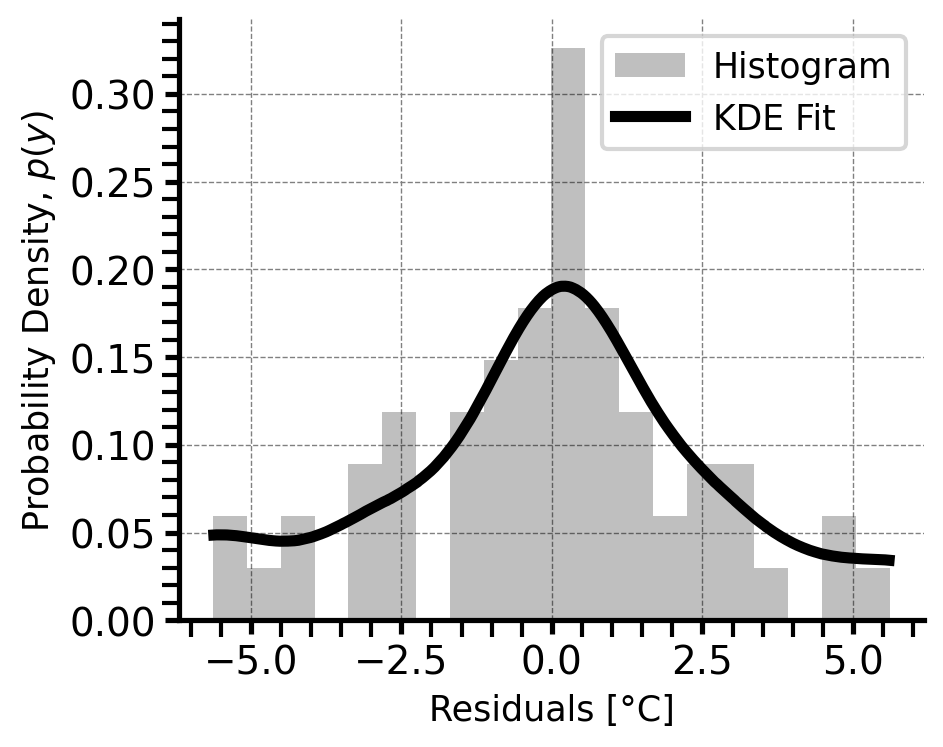

In [19]:
fig, ax = plot_density(y_error.median(dim=["draw", "chain"]))
ax.set(
    title="",
    xlabel="Residuals [°C]"
)
fig.set(
    dpi=100,
    size_inches=(5,4)
)
plt.tight_layout()
fig.savefig(figures_path.joinpath("metric_density_residuals_median.png"))
plt.show()

### Density - Residual Absolute Error

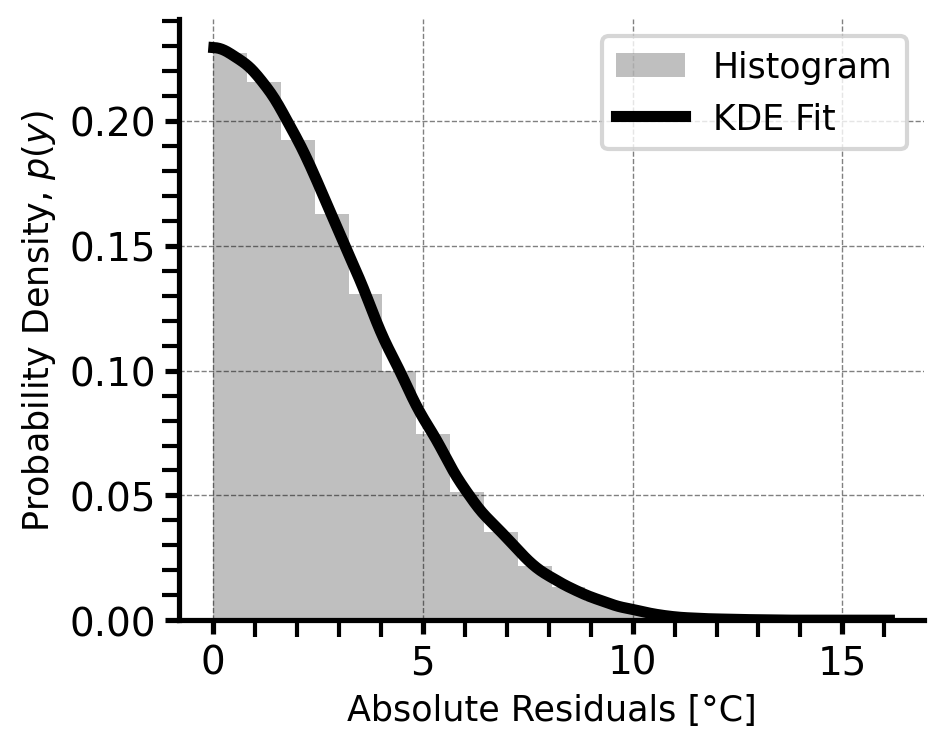

In [20]:
fig, ax = plot_density(np.abs(y_error))
ax.set(
    title="",
    xlabel="Absolute Residuals [°C]"
)
fig.set(
    dpi=100,
    size_inches=(5,4)
)
plt.tight_layout()
fig.savefig(figures_path.joinpath("metric_density_residuals_abs.png"))
plt.show()

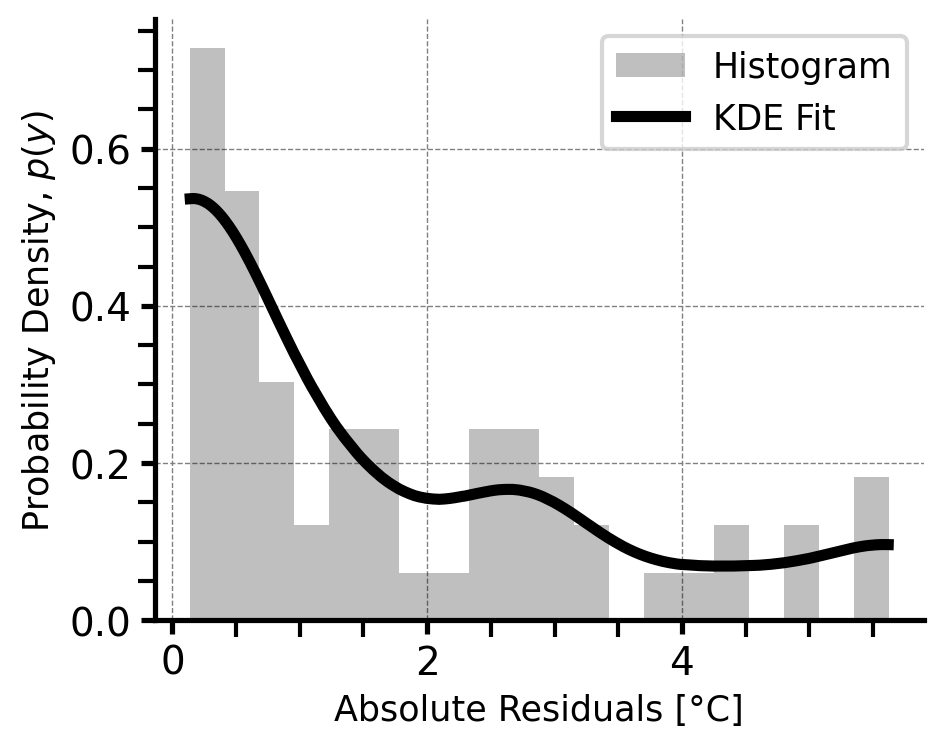

In [21]:
fig, ax = plot_density(np.abs(y_error.median(dim=["draw", "chain"])))
ax.set(
    title="",
    xlabel="Absolute Residuals [°C]"
)
fig.set(
    dpi=100,
    size_inches=(5,4)
)
plt.tight_layout()
fig.savefig(figures_path.joinpath("metric_density_residuals_median_abs.png"))
plt.show()

### QQ-Plot

In [22]:
# ====================
# results text
# ====================
y_pred_median = y_pred.mean(dim=["draw", "chain"])

metrics = {}
metrics["rmse"] = root_mean_squared_error(y_true, y_pred_median)
metrics["mae"] = mean_absolute_error(y_true, y_pred_median)
# MAPD% of original data
metrics['mapd'] = np.median(np.abs((y_pred_median) - (y_true)) / (y_true))
metrics

{'rmse': 2.4104223, 'mae': 1.8329766, 'mapd': 0.03213248}

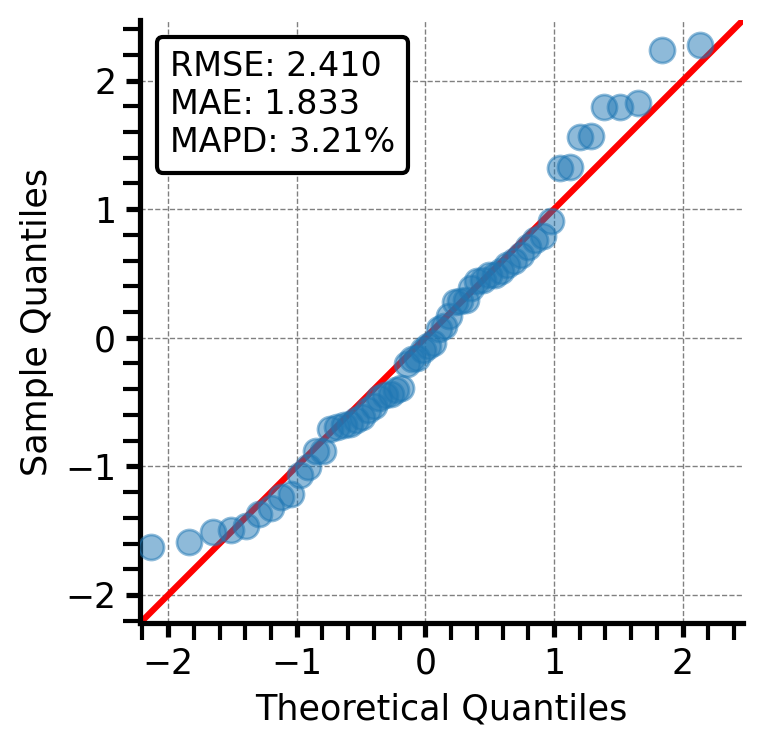

In [23]:
import statsmodels.api as sm
from scipy.stats import genextreme
from matplotlib.offsetbox import AnchoredText

# create Q-Q plot with 45-degree line added to plot
fig, ax = plt.subplots()

fig = sm.qqplot(y_pred_median, ax=ax, fit=True, line="45",  alpha=0.5, zorder=3)

text = f"RMSE: {metrics['rmse']:.3f}"
text += f"\nMAE: {metrics['mae']:.3f}"
text += f"\nMAPD: {metrics['mapd']:.2%}"
at = AnchoredText(
    text,
    prop=dict(fontsize=12), frameon=True,
    loc='upper left'
)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
ax.autoscale(enable=True, axis='both', tight=True)
plt.grid(True, linestyle='--', linewidth='0.5', color='gray')
plt.gca().set_aspect('equal')
plt.minorticks_on()
fig.set(
    dpi=100,
    size_inches=(5,4)
)
plt.tight_layout()
fig.savefig(figures_path.joinpath("qq_plot_fancy.png"))
plt.show()

## Predictions

### Regression Plot

In [24]:
locations = az_ds.predictions["location"].quantile(q=[0.025, 0.5, 0.975], dim=["chain", "draw"]).squeeze()
scales = az_ds.predictions["scale"].quantile(q=[0.025, 0.5, 0.975], dim=["chain", "draw"]).squeeze()
return_level_100 = az_ds.predictions["return_level_100"].quantile(q=[0.025, 0.5, 0.975], dim=["chain", "draw"]).squeeze()
observations = az_ds.observed_data.obs.squeeze()

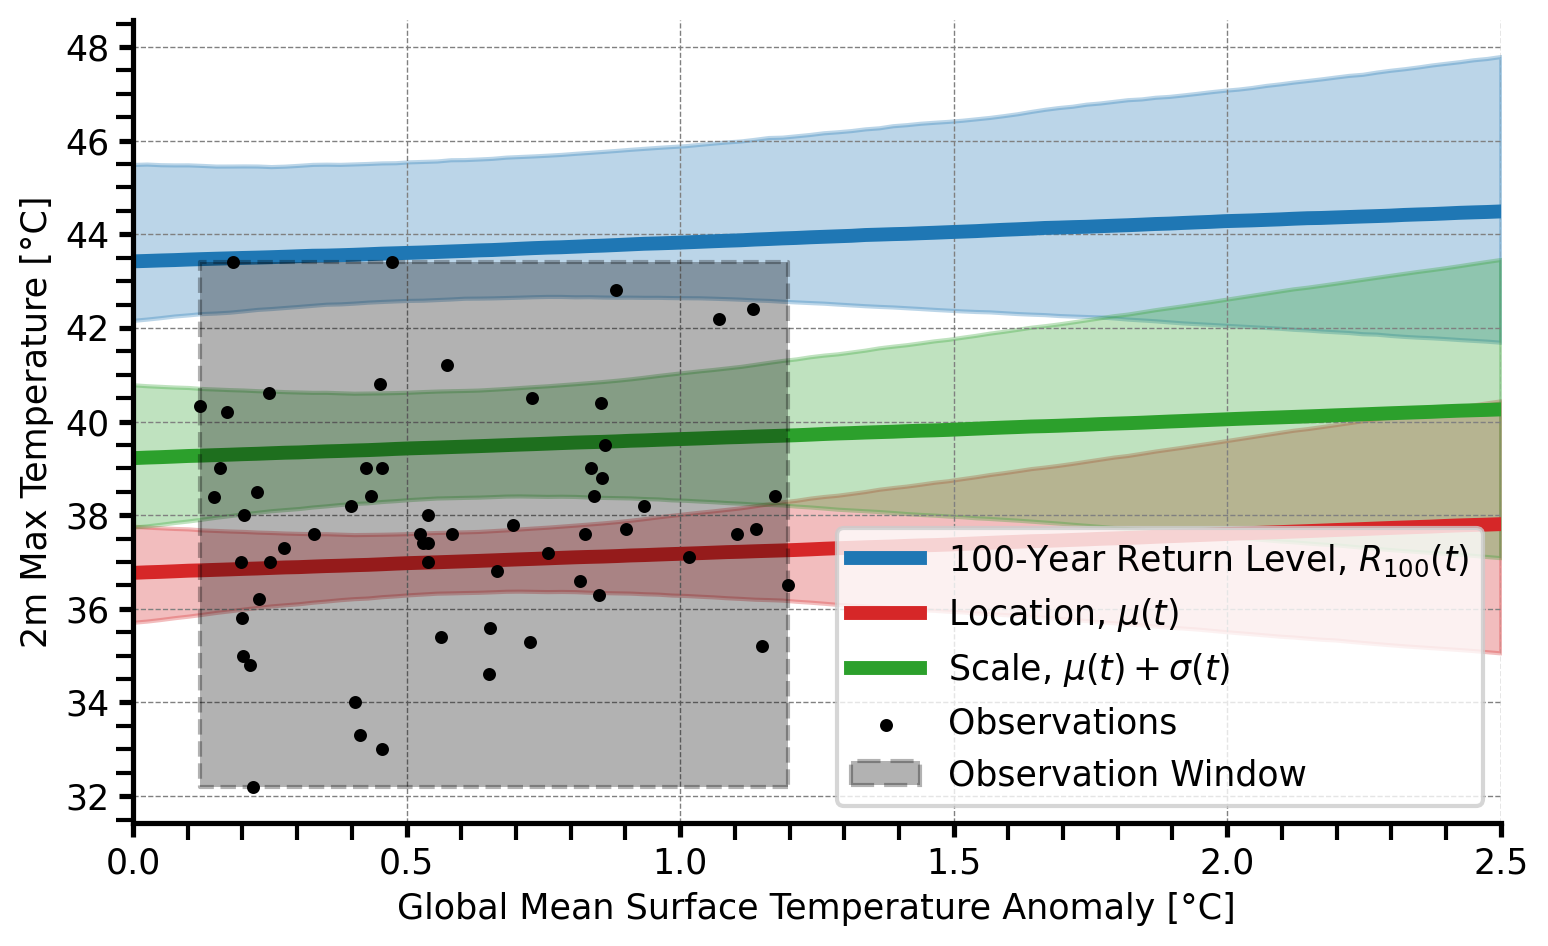

In [25]:
from st_evt.viz import plot_locationscale_return_regression

fig, ax = plot_locationscale_return_regression(
    locations,
    x_axis="gmst",
    scales=scales,
    returns=return_level_100,
    observations=observations,
)



ax.set(
    ylabel="2m Max Temperature [°C]",
    xlabel="Global Mean Surface Temperature Anomaly [°C]",
    xlim=[0.0, 2.5],
    # ylim=[-0.1, 1_000]
)
fig.set(
    dpi=100,
    size_inches=(8,5)
)
plt.tight_layout()
fig.savefig(figures_path.joinpath("reg_locscalereturns.png"))
plt.show()

### Return Period

In [26]:
rl_model = az_ds.predictions["return_level"].quantile(q=[0.025, 0.5, 0.975], dim=["chain", "draw"])

y_clean = az_ds.observed_data.dropna(dim="gmst").obs

In [27]:
y_clean["return_level"] = 1/xr.apply_ufunc(
    calculate_exceedence_probs,
    y_clean,
    input_core_dims=[["gmst"]],
    output_core_dims=[["gmst"]],
    vectorize=True
)
# y_clean["return_level"] = 1 / y_clean["return_level"]

In [28]:
ylabel = r"Daily Cumulative Precipitation, $R_a$" + "\n[mm/day]"

In [29]:
returns = []

returns.append({
    "color": "tab:green",
    "values":  rl_model.sel(gmst=0.0, method="nearest"),
    "label": r"Pre-Industrial, 0.0 [°C]"

})
returns.append({
    "color": "tab:blue",
    "values":  rl_model.sel(gmst=1.3, method="nearest"),
    "label": r"Current, 1.3 [°C]"
})

returns.append({
    "color": "tab:red",
    "values":  rl_model.sel(gmst=2.5, method="nearest"),
    "label": r"Future, 2.5 [°C]"
})

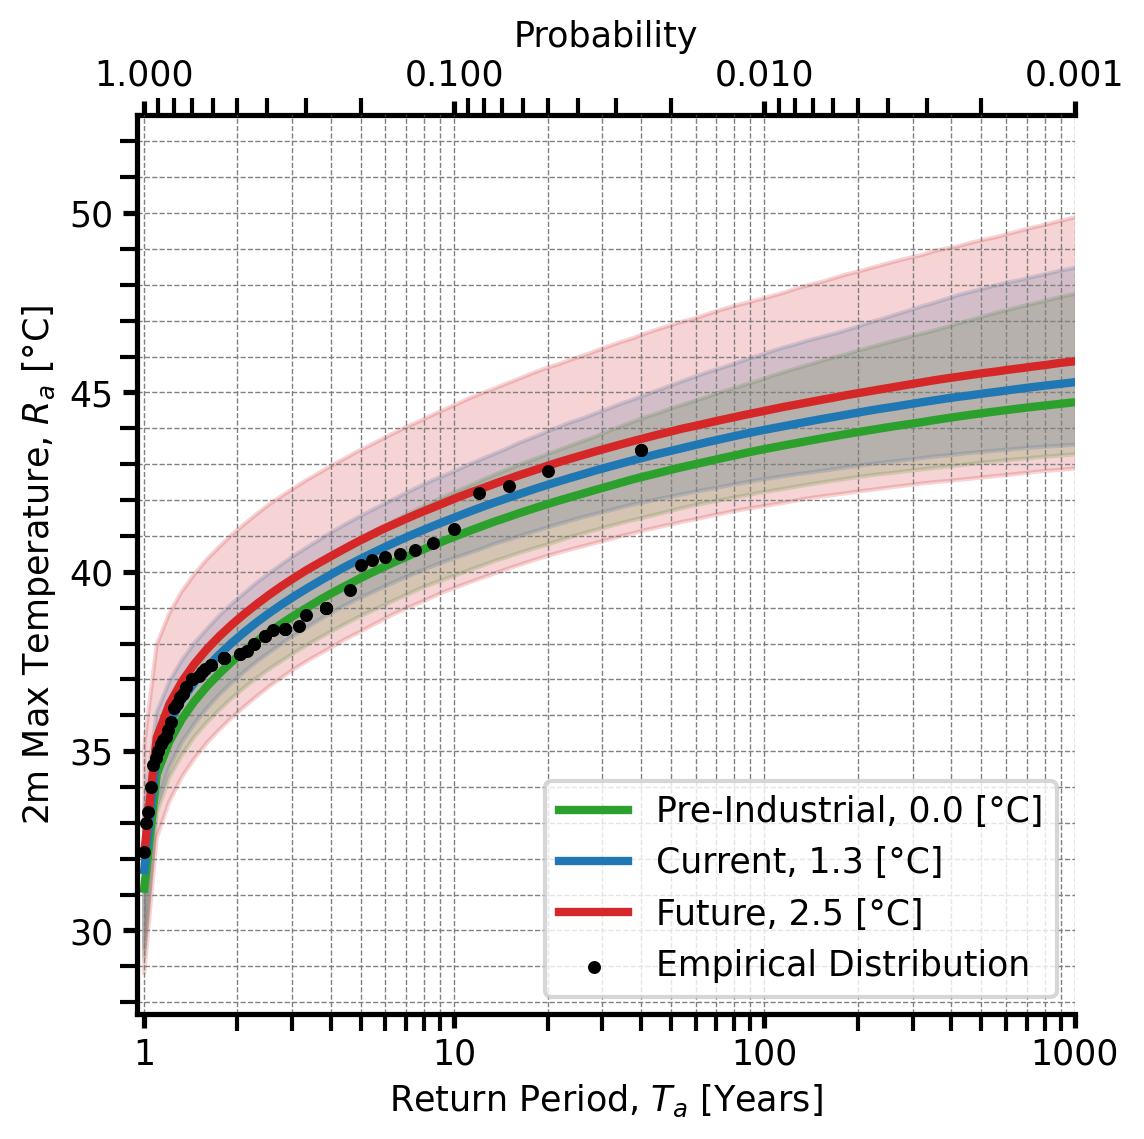

In [30]:
fig, ax = plot_return_level_gevd_manual_unc_multiple(
    returns,
    observations=y_clean
)
ax.set(
    ylabel="2m Max Temperature, $R_a$ [°C]",
    # ylim=[0, 1000]
)
fig.set(
    dpi=100,
    size_inches=(6,6)
)
plt.tight_layout()
fig.savefig(figures_path.joinpath("returns_prob_posterior_vs_empirical.png"))
plt.show()

### 100-Year Return Period

In [31]:
rl100_gmst = dict()
return_levels_100 = az_ds.predictions["return_level_100"]
quantiles = [0.025, 0.5, 0.975]
units = "[°C]"

rl100_gmst["historical"] = return_levels_100.sel(gmst=0.0, method="nearest").quantile(q=quantiles).values
rl100_gmst["current"] = return_levels_100.sel(gmst=1.3, method="nearest").quantile(q=quantiles).values
rl100_gmst["future"] = return_levels_100.sel(gmst=2.5,  method="nearest").quantile(q=quantiles).values

In [32]:
print(f"100-Year Return Period:")
print(f"Historical: \t{rl100_gmst['historical'][1]:.2f} ({rl100_gmst['historical'][0]:.2f}, {rl100_gmst['historical'][-1]:.2f}) {units}")
print(f"Current: \t{rl100_gmst['current'][1]:.2f} ({rl100_gmst['current'][0]:.2f}, {rl100_gmst['current'][-1]:.2f}) {units}")
print(f"Future: \t{rl100_gmst['future'][1]:.2f} ({rl100_gmst['future'][0]:.2f}, {rl100_gmst['future'][-1]:.2f}) {units}")

100-Year Return Period:
Historical: 	43.42 (42.16, 45.49) [°C]
Current: 	43.96 (42.51, 46.19) [°C]
Future: 	44.49 (41.69, 47.80) [°C]


In [33]:
returns = []

returns.append({
    "period": "Historical, 0.0 [°C]",
    "color": "green",
    "values":  return_levels_100.sel(gmst=0.0, method="nearest").values.ravel(),
    "values_units": "", # "[mm/day]",
})
returns.append({
    "period": "Current, 1.3 [°C]",
    "color": "blue",
    "values":  return_levels_100.sel(gmst=1.3, method="nearest").values.ravel(),
    "values_units": "", # "[mm/day]",
})
returns.append({
    "period": "Future, 2.5 [°C]",
    "color": "red",
    "values":  return_levels_100.sel(gmst=2.5, method="nearest").values.ravel(),
    "values_units": "", # "[mm/day]",
})

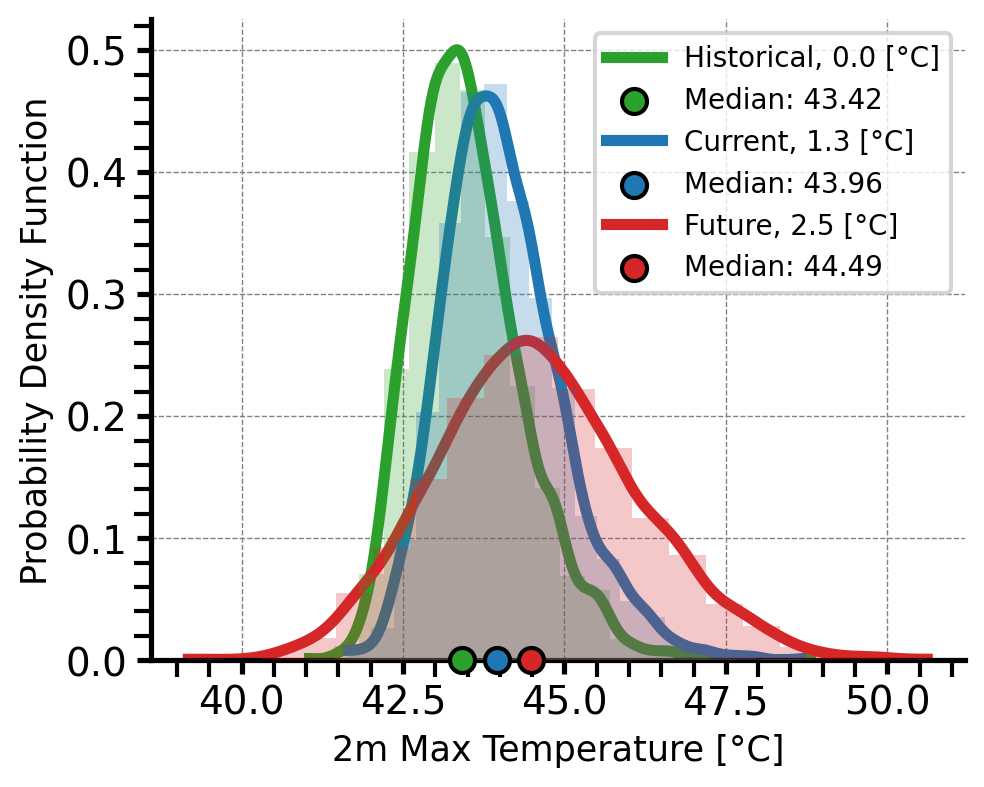

In [34]:
fig, ax = plot_periods(returns, log_bins=False)
fig.set_size_inches(6, 5)
# fig.set_size_inches(8, 4.5)
ax.set(
    xlabel=r"2m Max Temperature [°C]",
)

formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)
plt.legend(fontsize=10)
plt.tight_layout()
fig.set(
    dpi=100,
    size_inches=(5,4)
)
fig.savefig(figures_path.joinpath("rl100_gmst_density.png"))
plt.show()

### Difference - 100-Year Return Period

In [35]:
return_level_100 = az_ds.predictions["return_level_100"]

period_0 = return_level_100.sel(gmst=0.0, method="nearest")
period_1 = return_level_100.sel(gmst=1.3, method="nearest")
period_2 = return_level_100.sel(gmst=2.5, method="nearest")

diff_00_10 = period_1 - period_0

diff_10_20 = period_2 - period_1

In [36]:
rl100_gmst_diff = dict()
quantiles = [0.025, 0.5, 0.975]

rl100_gmst_diff["historical"] = diff_00_10.quantile(q=quantiles).values
rl100_gmst_diff["current"] = diff_10_20.quantile(q=quantiles).values

In [37]:
print(f"Difference:")
print(f"Current - Historical: \t{rl100_gmst_diff['historical'][1]:.2f} ({rl100_gmst_diff['historical'][0]:.2f}, {rl100_gmst_diff['historical'][-1]:.2f}) {units}")
print(f"Future - Current: \t{rl100_gmst_diff['current'][1]:.2f} ({rl100_gmst_diff['current'][0]:.2f}, {rl100_gmst_diff['current'][-1]:.2f}) {units}")


Difference:
Current - Historical: 	0.54 (-1.21, 2.25) [°C]
Future - Current: 	0.51 (-1.14, 2.12) [°C]


In [38]:
returns_diffs = []

returns_diffs.append({
    "period": "historical",
    "color": "tab:orange",
    "values":  diff_00_10,
    "values_units": "[°C]",
    "label": r"$\Delta$ GMST: Pre-Industrial $\rightarrow$ Current"
})
returns_diffs.append({
    "period": "current",
    "color": "tab:red",
    "values":  diff_10_20,
    "values_units": "[°C]",
    "label": r"$\Delta$ GMST: Current $\rightarrow$ Future"
})

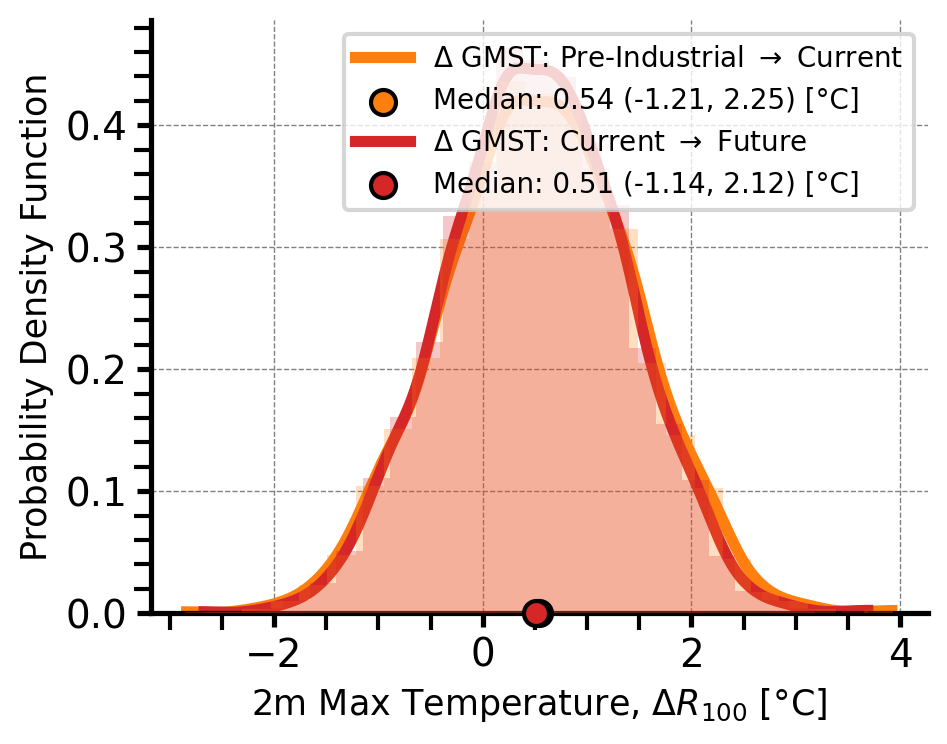

In [39]:
fig, ax = plot_periods_diff(returns_diffs)
fig.set_size_inches(6, 5)
ax.set(
    xlabel="2m Max Temperature, $\Delta R_{100}$ [°C]"
)
plt.legend(loc="upper right", fontsize=10)
fig.set(
    dpi=100,
    size_inches=(5,4)
)
plt.tight_layout()
fig.savefig(figures_path.joinpath("rl100_gmst_diff_density.png"))
plt.show()

### Percent Difference - 100-Year Return Period

**Percent Difference @ a Years**

$$
\text{PD}_a = 
\frac{R_a(t_1) - R_a(t_0)}{R_a(t_0)}
$$

In [40]:

rl100_gmst_diff_prct = dict()

rl100_gmst_diff_prct["historical"] = (diff_00_10 / np.abs(period_0)).quantile(q=quantiles).values * 100
rl100_gmst_diff_prct["current"] = (diff_10_20 / np.abs(period_1)).quantile(q=quantiles).values * 100

print(f"Percent Difference:")
p_statement = f"Current - Historical:"
p_statement += f"\t{rl100_gmst_diff_prct['historical'][1]:.2f}"
p_statement += f" ({rl100_gmst_diff_prct['historical'][0]:.2f}"
p_statement += f", {rl100_gmst_diff_prct['historical'][2]:.2f}) %"
print(p_statement)
p_statement = f"Future - Current:"
p_statement += f"\t{rl100_gmst_diff_prct['current'][1]:.2f}"
p_statement += f" ({rl100_gmst_diff_prct['current'][0]:.2f}"
p_statement += f", {rl100_gmst_diff_prct['current'][2]:.2f}) %"
print(p_statement)

Percent Difference:
Current - Historical:	1.24 (-2.72, 5.28) %
Future - Current:	1.16 (-2.63, 4.72) %


In [41]:
returns_diffs = []

returns_diffs.append({
    "period": "historical",
    "color": "tab:orange",
    "values":  (diff_00_10 / np.abs(period_0)) * 100,
    "values_units": "%",
    "label": r"$\Delta$ GMST: Pre-Industrial $\rightarrow$ Current"
})
returns_diffs.append({
    "period": "current",
    "color": "tab:red",
    "values":  (diff_10_20 / np.abs(period_1)) * 100,
    "values_units": "%",
    "label": r"$\Delta$ GMST: Current $\rightarrow$ Future"
})

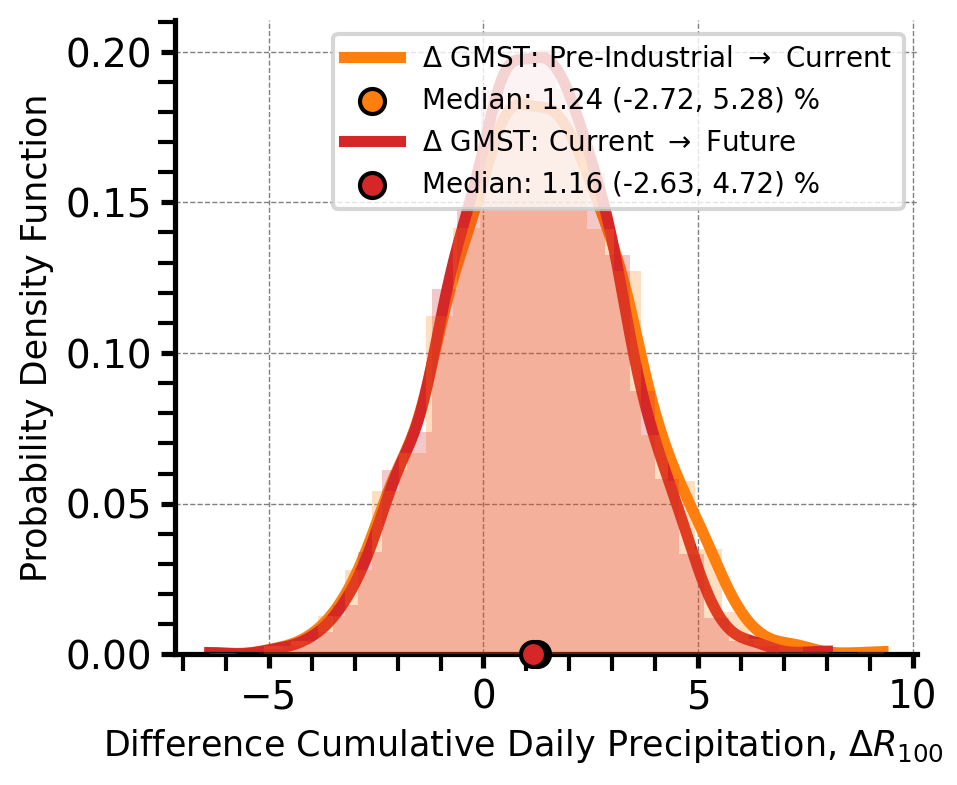

In [42]:
fig, ax = plot_periods_diff(returns_diffs)
fig.set_size_inches(6, 5)
ax.set(
    xlabel="Difference Cumulative Daily Precipitation, $\Delta R_{100}$ %"
)
plt.legend(loc="upper right", fontsize=10)
plt.tight_layout()
fig.set(
    dpi=100,
    size_inches=(5,4)
)
fig.savefig(figures_path.joinpath("rl100_gmst_diffprct_density.png"))
plt.show()

## Event Attribution

### Case Study I - WWA

#### Event

In [43]:
query_rl = 42.0


In [44]:
def interp_fn(return_level, return_period):

    out = np.interp(query_rl, xp=return_level, fp=return_period)
    return out
    

In [45]:
return_levels = az_ds.predictions["return_level"]

query_rp = xr.apply_ufunc(
    interp_fn,
    return_levels,
    return_levels.return_period,
    input_core_dims=[["return_period"], ["return_period"]],
    output_core_dims=[[]],
    vectorize=True,
)
query_rp.shape

(1, 100, 4000)

In [46]:
quantiles = [0.025, 0.5, 0.975]
query_rp_gmst= dict()
query_rp_gmst["historical"] = query_rp.sel(gmst=0.0,  method="nearest").quantile(q=quantiles).values
query_rp_gmst["current"] = query_rp.sel(gmst=1.3, method="nearest").quantile(q=quantiles).values
query_rp_gmst["future"] = query_rp.sel(gmst=2.5,  method="nearest").quantile(q=quantiles).values

In [47]:
print(f"Return Period @ Event {query_rl:.2f} [°C]:")
print(f"Historical: \t{query_rp_gmst['historical'][1]:.2f} ({query_rp_gmst['historical'][0]:.2f}, {query_rp_gmst['historical'][-1]:.2f}) [Years]")
print(f"Current: \t{query_rp_gmst['current'][1]:.2f} ({query_rp_gmst['current'][0]:.2f}, {query_rp_gmst['current'][-1]:.2f}) [Years]")
print(f"Future: \t{query_rp_gmst['future'][1]:.2f} ({query_rp_gmst['future'][0]:.2f}, {query_rp_gmst['future'][-1]:.2f}) [Years]")

Return Period @ Event 42.00 [°C]:
Historical: 	22.03 (8.50, 78.80) [Years]
Current: 	14.23 (6.09, 47.94) [Years]
Future: 	9.78 (2.52, 166.67) [Years]


#### Return Periods

In [48]:
returns = []

returns.append({
    "period": "Pre-Industrial",
    "period_units": "[°C]",
    "color": "green",
    "values":  query_rp.sel(gmst=0.0,  method="nearest").values.ravel(),
    "values_units": "[Years]",
    "label": "0.0"
})
returns.append({
    "period": "Current",
    "period_units": "[°C]",
    "color": "blue",
    "values": query_rp.sel(gmst=1.3, method="nearest").values.ravel(),
    "values_units": "[Years]",
    "label": "1.3"
})
returns.append({
    "period": "Future",
    "period_units": "[°C]",
    "color": "red",
    "values":  query_rp.sel(gmst=2.5,  method="nearest").values.ravel(),
    "values_units": "[Years]",
    "label": "2.5"
})

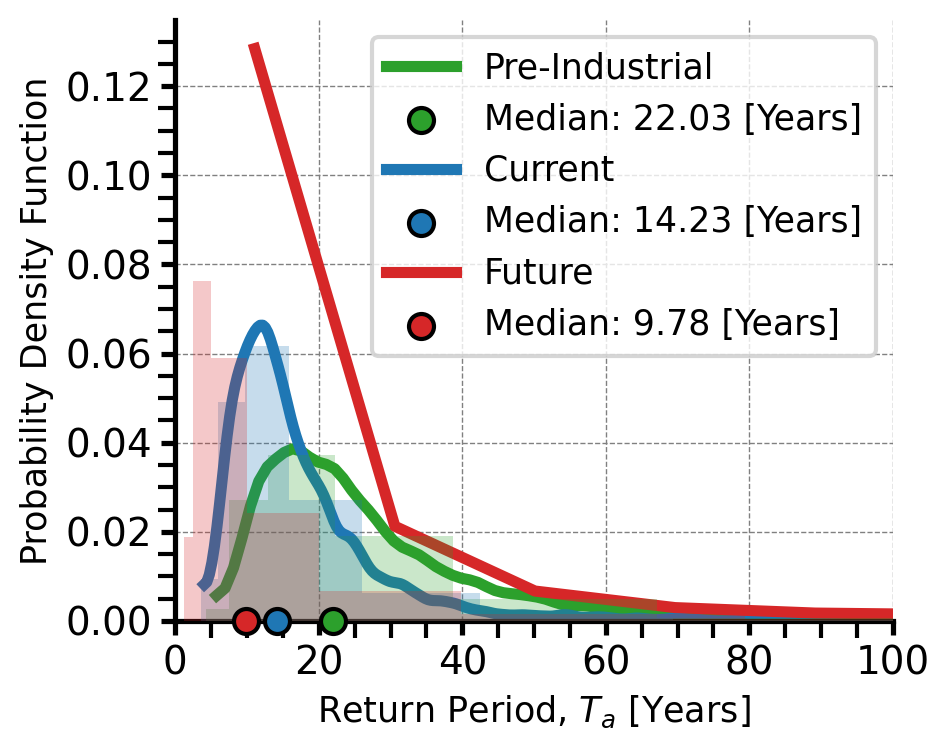

In [49]:
fig, ax = plot_periods(returns, log_bins=True)
ax.set(
    xlabel="Return Period, $T_a$ [Years]",
    xlim=[0, 100]
    
)
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)
plt.legend()
fig.set(
    dpi=100,
    size_inches=(5,4)
)
fig.savefig(figures_path.joinpath("attribution_rp_density.png"))
plt.show()

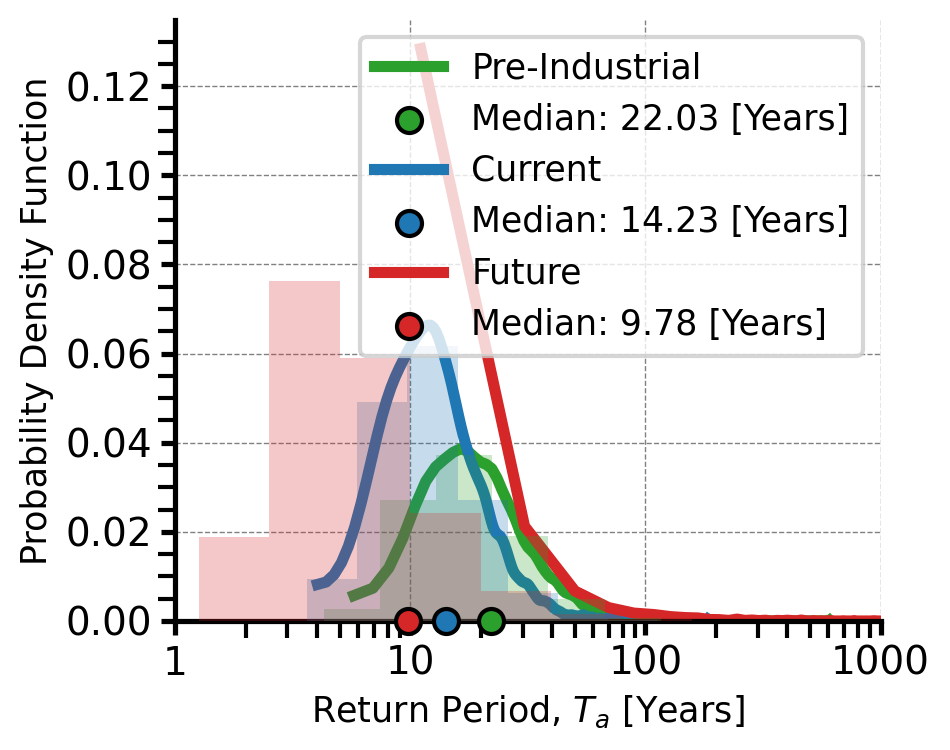

In [50]:
fig, ax = plot_periods(returns, log_bins=True)
ax.set(
    xlabel="Return Period, $T_a$ [Years]",
    xscale="log",
    xlim=[1, 1000]
)
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)
plt.legend()
fig.set(
    dpi=100,
    size_inches=(5,4)
)
fig.savefig(figures_path.joinpath("attribution_rp_density_log.png"))
plt.show()

#### Difference - Return Period

In [79]:
period_0 = query_rp.sel(gmst=0.0, method="nearest")
period_1 = query_rp.sel(gmst=1.3, method="nearest")
period_2 = query_rp.sel(gmst=2.5, method="nearest")

diff_00_10 = period_1 - period_0

diff_10_20 = period_2 - period_1

In [80]:
rl100_gmst_diff = dict()
quantiles = [0.025, 0.5, 0.975]

rl100_gmst_diff["historical"] = diff_00_10.quantile(q=quantiles).values
rl100_gmst_diff["current"] = diff_10_20.quantile(q=quantiles).values

In [81]:
print(f"Difference:")
print(f"Current - Historical: \t{rl100_gmst_diff['historical'][1]:.2f} ({rl100_gmst_diff['historical'][0]:.2f}, {rl100_gmst_diff['historical'][-1]:.2f}) [Years]")
print(f"Future - Current: \t{rl100_gmst_diff['current'][1]:.2f} ({rl100_gmst_diff['current'][0]:.2f}, {rl100_gmst_diff['current'][-1]:.2f}) [Years]")


Difference:
Current - Historical: 	-7.15 (-63.74, 26.58) [Years]
Future - Current: 	-3.50 (-10.94, 122.97) [Years]


In [82]:
returns_diffs = []

returns_diffs.append({
    "period": "historical",
    "color": "tab:orange",
    "values":  diff_00_10,
    "values_units": "[Years]",
    "label": r"$\Delta$ GMST: Pre-Industrial $\rightarrow$ Current"
})
returns_diffs.append({
    "period": "current",
    "color": "tab:red",
    "values":  diff_10_20,
    "values_units": "[Years]",
    "label": r"$\Delta$ GMST: Current $\rightarrow$ Future"
})

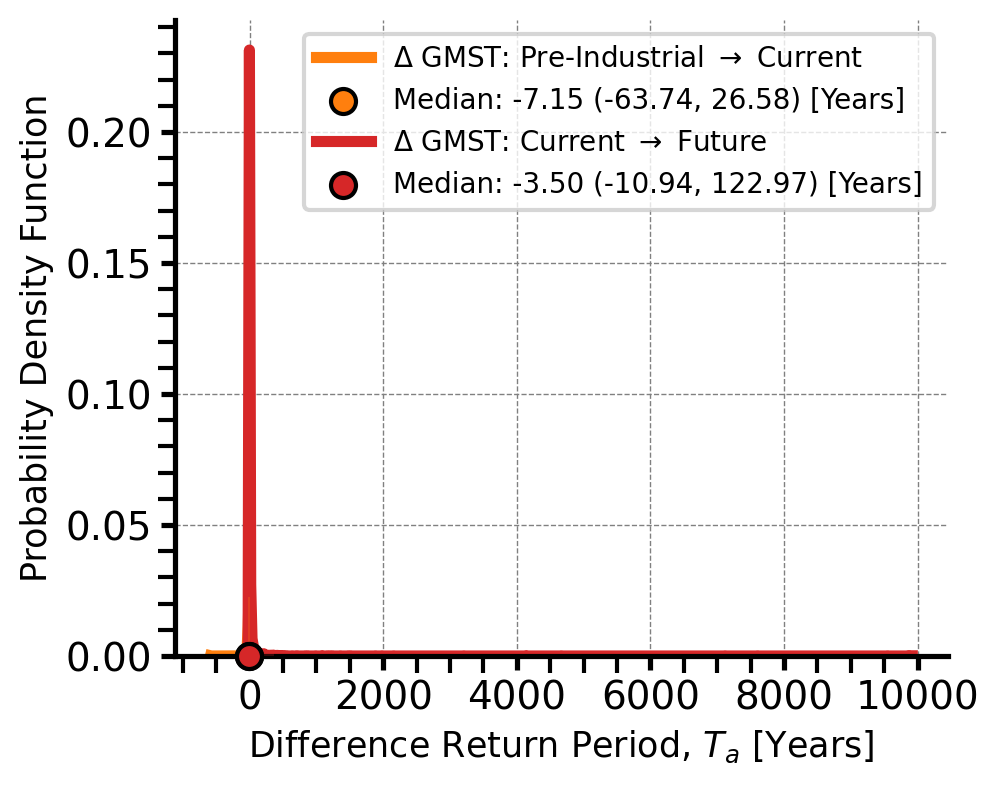

In [83]:
fig, ax = plot_periods_diff(returns_diffs)
fig.set_size_inches(6, 5)
ax.set(
    xlabel="Difference Return Period, $T_a$ [Years]",
    # xlim=[0, 100]
)
plt.legend(loc="upper right", fontsize=10)
plt.tight_layout()
fig.set(
    dpi=100,
    size_inches=(5,4)
)
fig.savefig(figures_path.joinpath("attribution_rp_diff_density.png"))
plt.show()

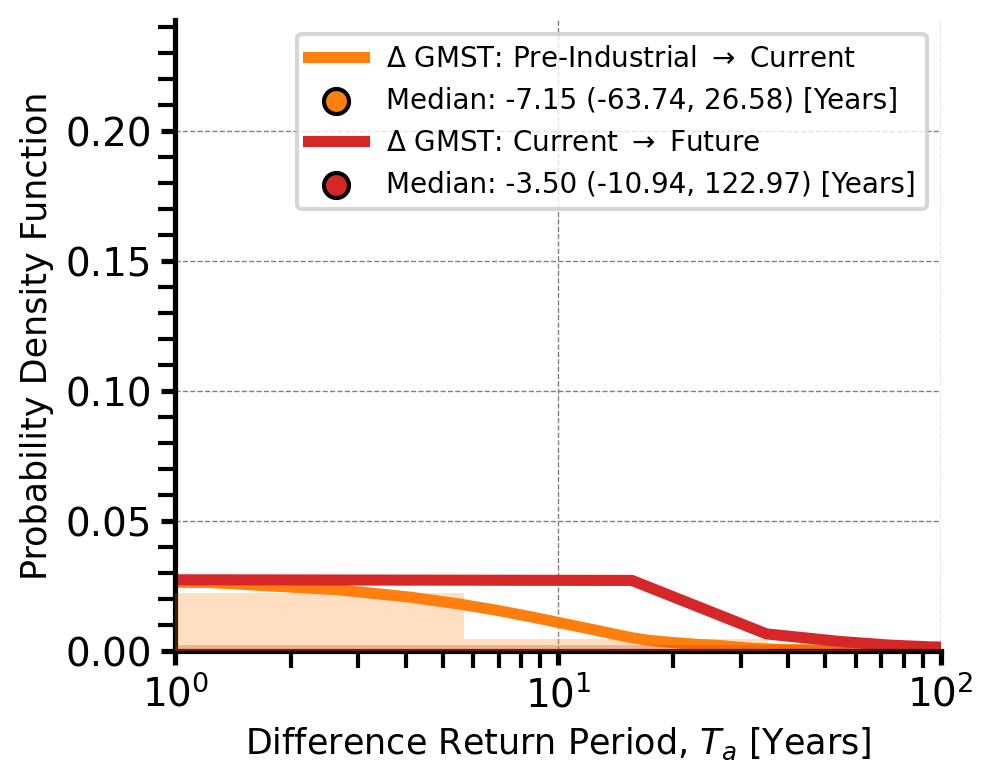

In [84]:
fig, ax = plot_periods_diff(returns_diffs)
fig.set_size_inches(6, 5)
ax.set(
    xlabel="Difference Return Period, $T_a$ [Years]",
    xlim=[1, 100],
    xscale="log"
)
plt.legend(loc="upper right", fontsize=10)
plt.tight_layout()
fig.set(
    dpi=100,
    size_inches=(5,4)
)
fig.savefig(figures_path.joinpath("attribution_rp_diff_density_log.png"))
plt.show()